<a href="https://colab.research.google.com/github/shilpasy/Projects_partof_DataScienceFellowship_Python/blob/main/time_series_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import seaborn as sns
sns.set()

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
from static_grader import grader
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn import base
from sklearn.linear_model import LinearRegression

# Time Series Data: Predict Temperature

Time series prediction presents its own challenges which are different from machine-learning problems.  As with many other classes of problems, there are a number of common features in these predictions.


## A note on scoring

It **is** possible to score >1 on these questions. This indicates that you've beaten our reference model - we compare our model's score on a test set to your score on a test set. See how high you can go!


## Fetch the data:

In [ ]:
!aws s3 sync s3://dataincubator-course/mldata/ . --exclude '*' --include 'train.v2.csv.gz'

The data can be loaded into pandas easily:

In [ ]:
df = pd.read_csv('train.v2.csv.gz')
print(df.shape)
df.head()

(392136, 9)


,station,time,temp,dew_point,pressure,wind_speed,wind_direction,precip_hour,weather_codes
0,PHX,2010-01-01 00:51,62.06,15.98,1024.90,3.00,20.00,M,M
1,PHX,2010-01-01 01:51,60.08,17.96,1025.30,4.00,50.00,M,M
2,PHX,2010-01-01 02:51,59.00,17.96,1025.60,4.00,30.00,M,M
3,PHX,2010-01-01 03:51,53.96,21.92,1026.00,0.00,0.00,M,M
4,PHX,2010-01-01 04:51,55.94,17.06,1026.20,5.00,40.00,M,M


The `station` column indicates the city.  The `time` is measured in UTC.  Both `temp` and `dew_point` are measured in degrees Fahrenheit.  The `wind_speed` is in knots, and the `precip_hour` measures the hourly precipitation in inches.

Missing values are indicated by a flag value.  Remove rows without valid temperature measurements.  You may also want to change some data types. (But keep in mind that the data provided by the grader will have the same data types as `pd.read_csv` provided.)

In [ ]:
invalid_temp_entries = df.index[df.temp.str.contains('M')]
df = df.drop(invalid_temp_entries)

In [ ]:
print(df.dtypes)

station           object
time              object
temp              object
dew_point         object
pressure          object
wind_speed        object
wind_direction    object
precip_hour       object
weather_codes     object
dtype: object


We will focus on using the temporal elements to predict the temperature.


# Questions


For each question, build a model to predict the temperature in a given city at a given time.  You will be given a DataFrame, as we got from `pd.read_csv`.  (As you can imagine, the temperature values will be nonsensical in the DataFrame you are given.)  Return a collection of predicted temperatures, one for each incoming row in the DataFrame.  

## One-city model

As you may have noticed, the data contains rows for multiple cities.  We'll deal with all of them soon, but for this first question, we'll focus on only the data from New York (`"NYC"`).  Start by isolating only those rows.

Seasonal features are nice because they are relatively safe to extrapolate into the future. There are two ways to handle seasonality.  

The simplest (and perhaps most robust) is to have a set of indicator variables. That is, make the assumption that the temperature at any given time is a function of only the month of the year and the hour of the day, and use that to predict the temperature value.

**Question**: Should month be a continuous or categorical variable?  (Recall that [one-hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) is useful to deal with categorical variables.)

Build a model to predict the temperature for a given hour in a given month in New York.

In [ ]:
for col in ['dew_point', 'pressure', 'wind_speed','wind_direction', 'precip_hour', 'temp']:
    df[col] = pd.to_numeric(df[col],errors='coerce')
    df[col].fillna(0,inplace=True)

# 'station', 'time', 'temp', 'dew_point', 'pressure', 'wind_speed', 'wind_direction', 'precip_hour', 'weather_codes', 'month', 'hour'

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

class ExtractMonthHour(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['time'] = pd.to_datetime(X['time'], format="%Y-%m-%d %H:%M:%S")
        X['month'] = X['time'].dt.month
        X['hour'] = X['time'].dt.hour
        return X

features = ColumnTransformer([('categorical', OneHotEncoder(), ['month', 'hour'])])

city_model = Pipeline([
        ('extract_month_hour', ExtractMonthHour()),
        ('features', features),
        ('regressor', Ridge())
])

df_nyc = df[df['station'] =='NYC']

X = df_nyc.drop(columns=['temp'])
y = df_nyc['temp']

nyc_model = city_model.fit(X,y)

The grader will provide a DataFrame in the same format as `pd.read_csv` provided.  All of the temperature data will be redacted.  As long as your model accepts DataFrame input, you should be able to run the grader line below as-is.  If your model is expecting a different input, you will need to write an adapter function.

In [ ]:
grader.score('ts__one_city_model', nyc_model.predict)

Your score: 1.0000


In [ ]:
X[['month', 'hour']]

,month,hour
314317,1,0
314318,1,1
314319,1,2
314320,1,3
314321,1,4
...,...,...
392131,12,19
392132,12,20
392133,12,21
392134,12,22


## Per-city model

Now we want to extend this same model to handle all of the cities in our data set.  Rather than adding features to the existing model to handle this, we'll just make a new copy of the model for each city.

If your model is a single class, then this is easy&mdash;you can just instantiate your class once per city.  But it's more likely your model was a particular instance of a Pipeline.  If that's the case, make a **factory function** that returns a new copy of that Pipeline each time it's called.

In [ ]:
# #def season_factory():
# #    return city_model() # A single estimator or a pipeline

# def season_factory():
#     return city_model.clone() ?????????????

Calling this function should give a new copy of the Pipeline.  If we train that new copy on the New York data, it should give us the same model as before.  (You might check this by submitting such a model to the previous `grader.score` call.)

While we could manually call this function for each city in our dataset, let's build a "group-by" estimator that does this for us.  This estimator should take a column name and a factory function as an argument.  The `fit` method will group the incoming data by that column, and for each group it will call the factory to create a new instance to be trained by on that group.  Then, the `predict` method should look up the corresponding model for each row and perform a predict using that model.

Now, we should be able to build an equivalent model for each city:

Again, as long as this model accepts a DataFrame as input, you should be able to pass the `predict` method to the grader.

In [ ]:
# def season_factory():
#     return Pipeline([
#         ('extract_month_hour', ExtractMonthHour()),
#         ('features', features), #OHE
#         ('regressor', Ridge())
# ])


# class GroupbyEstimator(base.BaseEstimator, base.RegressorMixin):

#     def __init__(self, column, estimator_factory):
#         self.column = column
#         self.estimator_factory = estimator_factory
#         self.models = {}

#     def fit(self, X, y):
#         X_mod = X#.drop(columns=['temp'])
#         grouped_data = X_mod.groupby(self.column)
#         for name, group in grouped_data:
#             model = self.estimator_factory()
#             self.models[name] = model.fit(group, y[group.index])
#         return self

#     def predict(self, X):
#         predictions = []
#         idxs = []
#         X_mod = X#.drop(columns=['temp'])
#         grouped_data = X_mod.groupby(self.column)
#         for name,group in grouped_data:
# #             print(name)
#             pred = []
#             idx = []
#             model = self.models[name]
#             pred.append(model.predict(group))
#             idx.append(group.index)
# #             print(idx)
#             predictions.append(model.predict(group))
#             idxs.append(idx)
#         print(predictions)
#         print(idxs)

#         np_pred = [item for sublist in predictions for item in sublist]
#         idx_pred = [item for sublist in idxs for supersublist in sublist for item in supersublist]

#         df_dict = {"predictions" :np_pred,"idx":idx_pred }
#         #create dataframe from two lists
#         df = pd.DataFrame(df_dict)
#         df.sort_values(by="idx",inplace=True)

#         return df["predictions"]

# season_model = GroupbyEstimator('station', season_factory).fit(df, df['temp'])


In [ ]:
grader.score('ts__month_hour_model', season_model.predict)

NameError: name 'season_model' is not defined

## Handling data in arbitrary order

Submit the same model again to the following scorer:

In [ ]:
def season_factory():
    return Pipeline([
        ('extract_month_hour', ExtractMonthHour()),
        ('features', features), #OHE features
        ('regressor', Ridge())
])

class GroupbyEstimator(base.BaseEstimator, base.RegressorMixin):

    def __init__(self, column, estimator_factory):
        self.column = column
        self.estimator_factory = estimator_factory
        self.models = {}

    def fit(self, X, y):
        #grouping the data by "station" i.e. city names
        grouped_data = X.groupby(self.column)
        for name, group in grouped_data:
            model = self.estimator_factory() #creating at estimator/season factory for each city
            self.models[name] = model.fit(group, y[group.index]) # fitting for each city seperately, hence y[group.index]
        return self

    def predict(self, X):

#         pop out the index of this dataframe and store as a column.
#         Then store the column as a separate index or dataframe
#         and sort the final predictions accordingly.
        predictions = []
        idxs = []
        namelst = []
        idxdf = pd.DataFrame(X.index,columns=["idx"])
        #print(idxdf)
        grouped_data = X.groupby(self.column)
        for name,group in grouped_data:
#             print(group)
            pred = []
            idx = []
            model = self.models[name]
            pred.append(model.predict(group))
            idx.append(group.index)
            namelst.append(name)
            predictions.append(model.predict(group))
            idxs.append(idx)
#           print(namelst)

        np_pred = [item for sublist in predictions for item in sublist]
        idx_pred = [item for sublist in idxs for supersublist in sublist for item in supersublist]

        df_dict = {"predictions" :np_pred,"idx":idx_pred }

        #create dataframe from two lists
        df = pd.DataFrame(df_dict)
        finaldf = pd.merge(left = idxdf, right = df, on = "idx", how="left")
        #print(finaldf)
        return finaldf["predictions"]

season_model = GroupbyEstimator('station', season_factory).fit(df, df['temp'])


In [ ]:
grader.score('ts__shuffled_model', season_model.predict)

If you passed, congratulations&mdash;you avoided a common pitfall!  Move on to the next question.

But if your model suddenly behaved worse: In the previous question, we provided each city's rows in contiguous groups.  In this question, the rows were all shuffled together.  If you were predicting for a group at a time and just appending those grouped predictions for the final output, it'll be in the wrong order.

There are two ways to fix this:
1. Predict for each row individually.  This is straightforward, but very, _very_ slow.
2. Predict for each group, and then reorder the predictions to match the input order.  A common way to do this is to attach the index of the feature matrix to the predictions, and then order the full prediction series by the index of the feature matrix.

Once you've fixed your `GroupbyEstimator.predict` method, resubmit to this question.

## Fourier model

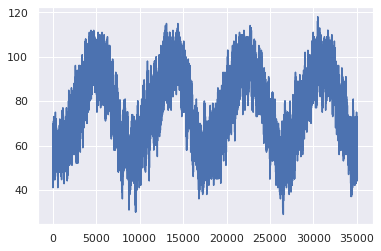

In [ ]:
df.temp[:365*24*4].plot();

In [ ]:
df['time'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S")
df['month'] = df['time'].dt.month
df['hour'] = df['time'].dt.hour
df.head()

,station,time,temp,dew_point,pressure,wind_speed,wind_direction,precip_hour,weather_codes,month,hour
0,PHX,2010-01-01 00:51:00,62.06,15.98,1024.9,3.0,20.0,0.0,M,1,0
1,PHX,2010-01-01 01:51:00,60.08,17.96,1025.3,4.0,50.0,0.0,M,1,1
2,PHX,2010-01-01 02:51:00,59.00,17.96,1025.6,4.0,30.0,0.0,M,1,2
3,PHX,2010-01-01 03:51:00,53.96,21.92,1026.0,0.0,0.0,0.0,M,1,3
4,PHX,2010-01-01 04:51:00,55.94,17.06,1026.2,5.0,40.0,0.0,M,1,4


In [ ]:
Xtime = df['time']
Xtime[0]

Timestamp('2010-01-01 00:51:00')

In [ ]:
diff = Xtime - Xtime[0]
diff[100]

In [ ]:
#sns.lineplot(data=df, y= df['temp'], x=df['month'])

In [ ]:
#sns.lineplot(data=df, y= df['temp'], x=df['hour'])

Let's consider another way to deal with the seasonal terms.  Since we know that temperature is roughly sinusoidal, we know that a reasonable model might be

$$ y_t = y_0 \sin\left(2\pi\frac{t - t_0}{T}\right) + \epsilon $$

where $y_0$ and $t_0$ are parameters to be learned and $T$ is the period - one year for seasonal variation, one day for daily, etc.  While this is linear in $y_0$, it is not linear in $t_0$. However, we know from Fourier analysis, that the above is
equivalent to

$$ y_t = A \sin\left(2\pi\frac{t}{T}\right) + B \cos\left(2\pi\frac{t}{T}\right) + \epsilon $$

which is linear in $A$ and $B$.

Create a model containing sinusoidal terms on one or more time scales, and fit it to the data using a linear regression.  Build a `fourier_factory` function that will return instances of this model.

In [ ]:
class FourierComponents(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, period):
        self.period = period

    def fit(self, X, y=None):
        self.X0 = X.iloc[0]
        return self

    def transform(self, X):
        dt = ((X - self.X0).dt.days + (X - self.X0).dt.seconds /(3600 * 24)) * 2 * np.pi / self.period
        return np.c_[np.sin(dt), np.cos(dt)]

In [ ]:
fourier_features = ColumnTransformer([('fcy', FourierComponents(1), 'time'), ('fcd', FourierComponents(365), 'time')])

def fourier_factory():
    return Pipeline([
        ('extract_month_hour', ExtractMonthHour()),
        ('FF', fourier_features), ###fourier_features.fit_transform()
        #('lr', LinearRegression())
        ('regressor', Ridge())])

In [ ]:
fc = FourierComponents(1)
#fc.fit_transform(Xtime)[:24]

In [ ]:
fourier_features = ColumnTransformer([('fcy', FourierComponents(1), 'time'), ('fcd', FourierComponents(365), 'time')])
fourier_features.fit_transform(df)

In [ ]:
ExtractMonthHour().fit

In [ ]:
fourier_features.fit_transform(ExtractMonthHour().fit_transform(df))

In [ ]:
Rg = Ridge().fit(fourier_features.fit_transform(ExtractMonthHour().fit_transform(df)), df['temp'])

In [ ]:
# GroupbyEstimator('station', Rg).fit(df, df['temp'])

In [ ]:
#GroupbyEstimator('station', Rg).fit(df, df['temp'])

In [ ]:
X = df_nyc.drop(columns = ['temp'])
y = df_nyc['temp']
GroupbyEstimator('station', fourier_factory).fit(X,y)
#GroupbyEstimator('station', season_factory).fit(X,y)

A general `GroupByEstimator` should be able to take the new factory function and build a model for each city.

In [ ]:
fourier_model = GroupbyEstimator('station', fourier_factory).fit(df, df['temp'])

Submit this model to the grader.

In [ ]:
grader.score('ts__fourier_model', fourier_model.predict)